----

# Qdrant & Image Data

---

In [1]:
## Install docker and pull/run Qdrant docker on Compute shape.

In [2]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch

## **Connect to Qdrant and create new collection**

In [3]:
client = QdrantClient(host="207.211.188.211", port=6333)

In [4]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

## **Load meta data for each bag**

In [5]:
import pandas as pd
df = pd.read_excel("./bags_overview.xlsx")
df

,image_x,colour,belt_colour,chain,handle,lock,spots
0,img_1,black,gold,no chain,black handle,no lock,no spots
1,img_2,black,silver,no chain,black handle,no lock,no spots
2,img_3,black,silver,no chain,black handle,no lock,no spots
3,img_4,black,gold,golden chain,no handle,golden lock,no spots
4,img_5,black,gold,no chain,black handle,golden lock,no spots
5,img_6,black,gold,no chain,black handle,golden lock,no spots
6,img_7,black,no belt,no chain,black handle,no lock,silver spots
7,img_8,black,no belt,no chain,black handle,no lock,silver spots
8,img_9,black,no belt,no chain,black handle,no lock,no spots
9,img_10,white,no belt,no chain,white handle,no lock,silver spots


## **Create embedding from each image**

In [16]:
!mkdir ./images_handbag

## add the images to the folder

mkdir: cannot create directory ‘./images_handbag’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
from PIL import Image
import requests
import os
from os import listdir
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

empty_list = []


folder_dir = "./images_handbag/"
for images in os.listdir(folder_dir):
    
    if (images.endswith(".png")):
    
        print(images)

        image = Image.open(folder_dir + images)

        #convert to vector (text is not relevant for now)
        inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

        outputs = model(**inputs)
        image_embedding = outputs.image_embeds  #tensor

        #convert tensor to numpy array
        iamge_embedding_np = image_embedding[0].cpu().detach().numpy()

        empty_list.append(iamge_embedding_np)
    
#list to array
mat = np.array(empty_list)

#save np array
np.save("vectors", np.array(mat), allow_pickle=False)

ids = list(range(df.shape[0]))  #size of dataframe
embeddings = np.load("vectors.npy").tolist()   #load array of vectors

img_3.png
img_2.png
img_15.png
img_7.png
img_5.png
img_4.png
img_14.png
img_12.png
img_6.png
img_11.png
img_9.png
img_10.png
img_13.png
img_1.png
img_8.png


In [7]:
## **Convert Meta data to correct JSON payload

In [8]:
payload = df.to_dict(orient="records")

payload[:3]

[{'image_x': 'img_1',
  'colour': 'black',
  'belt_colour': 'gold',
  'chain': 'no chain',
  'handle': 'black handle',
  'lock': 'no lock',
  'spots': 'no spots'},
 {'image_x': 'img_2',
  'colour': 'black',
  'belt_colour': 'silver',
  'chain': 'no chain',
  'handle': 'black handle',
  'lock': 'no lock',
  'spots': 'no spots'},
 {'image_x': 'img_3',
  'colour': 'black',
  'belt_colour': 'silver',
  'chain': 'no chain',
  'handle': 'black handle',
  'lock': 'no lock',
  'spots': 'no spots'}]

## **Push image embeddings and related meta data per image to qdrant**

In [9]:
batch_size = 1

for i in range(0, df.shape[0], batch_size):

    low_idx = min(i+batch_size, df.shape[0],)
    print(low_idx)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


## **See number of records**

In [10]:
client.count(
    collection_name=my_collection,
    exact=True,
)

CountResult(count=15)

## **Search Images with an Image Embedding, return top 3**

In [11]:
results = client.search(
    collection_name=my_collection,
    query_vector=embeddings[14],
    limit=3
)

In [12]:
results

[ScoredPoint(id=14, version=14, score=1.0000001, payload={'belt_colour': 'no belt', 'chain': 'no chain', 'colour': 'white', 'handle': 'white handle', 'image_x': 'img_15', 'lock': 'no lock', 'spots': 'no spots'}, vector=None),
 ScoredPoint(id=7, version=7, score=0.92293125, payload={'belt_colour': 'no belt', 'chain': 'no chain', 'colour': 'black', 'handle': 'black handle', 'image_x': 'img_8', 'lock': 'no lock', 'spots': 'silver spots'}, vector=None),
 ScoredPoint(id=3, version=3, score=0.9217955, payload={'belt_colour': 'gold', 'chain': 'golden chain', 'colour': 'black', 'handle': 'no handle', 'image_x': 'img_4', 'lock': 'golden lock', 'spots': 'no spots'}, vector=None)]

## **See top 3 images returned by Qdrant**

In [17]:
def see_images(results, top_k=5):
    for i in range(top_k):
        image_x = results[i].payload['image_x']
        belt_colour    = results[i].payload['belt_colour']
        colour       = results[i].payload['colour']
        handle   = results[i].payload['handle']
        lock      = results[i].payload['lock']
        spots      = results[i].payload['spots']
        
        image = Image.open("./images_handbag/" + image_x + ".png")
        display(image)
        print("-" * 50)
        print()

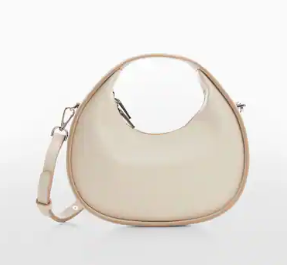

--------------------------------------------------



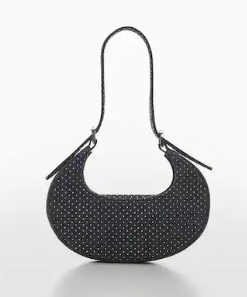

--------------------------------------------------



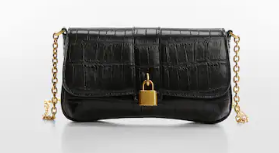

--------------------------------------------------



In [18]:
see_images(results, 3)

## **- Extra, small Gradio application to test**

## **Full function**

In [24]:

def see_images(results, top_k=1):
    for i in range(top_k):
        image_x = results[i].payload['image_x']
        belt_colour    = results[i].payload['belt_colour']
        colour       = results[i].payload['colour']
        handle   = results[i].payload['handle']
        lock      = results[i].payload['lock']
        spots      = results[i].payload['spots']
        
        print("--" *25)
        print(image_x)
        
        image = Image.open("./images_handbag/" + image_x + ".png")
        output_image = "./images_handbag/" + image_x + ".png"
        
        
        
        display(image)
        print("-" * 50)
        print()
        
    return output_image, belt_colour, colour, handle, lock, spots

def full_function(input_image):
    
    
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    empty_list = []

    print(input_image)

    image = Image.open(input_image)

    #convert to vector (text is not relevant for now)
    inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    image_embedding = outputs.image_embeds  #tensor
    #print(image_embedding)

    #convert tensor to numpy array
    image_embedding_np = image_embedding[0].cpu().detach().numpy()
    
    results = client.search(
    collection_name=my_collection,
    query_vector=image_embedding_np,
    limit=1
    )
    
    #print(results)
    
    
    output_image, belt_colour, colour, handle, lock, spots = see_images(results)
    
    return output_image, belt_colour, colour, handle, lock, spots


    
    
    

./images_handbag/img_4.png
--------------------------------------------------
img_6


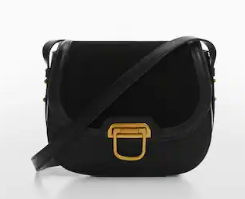

--------------------------------------------------



In [25]:
output_image, belt_colour, colour, handle, lock, spots = full_function("./images_handbag/img_4.png")

In [ ]:
import gradio as gr

desc = "Matching Handbags"

with gr.Blocks() as demo: 
     
    input_image = gr.Image(label="Input image", type='filepath')

    output_image_1 = gr.Image(label="Matched image 1")
    belt_colour = gr.Text(label="Belt Colour")
    colour = gr.Text(label="Colour")
    handle = gr.Text(label="Handle")
    lock = gr.Text(label="Lock")
    spots = gr.Text(label="Spots")

    submit_btn = gr.Button("Run the analysis")

gr.Interface(fn=full_function, inputs=input_image, outputs=[output_image_1, belt_colour, colour, handle, lock, spots], title=desc).launch(share=True, debug=True)

Running on local URL:  http://127.0.0.1:7860


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://0cb25294e82c872312.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
